In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [15]:
learning_rate = 0.0001
training_iters = 4800000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)
    fc3 = tf.add(tf.matmul(fc2, weights['wd3']), biases['bd3'])
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3, dropout)
    print(fc3.shape)

    # Output, class prediction
    fc4 = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
    print(fc4.shape)
    return fc4

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # fully connected, 3*4*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([3*4*64, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # fully connected, 512 inputs, 1024 outputs
    'wd3': tf.Variable(tf.random_normal([512, 1024])),
    # 1024 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'bd3': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 1024)
(?, 512)
(?, 1024)
(?, 14)


# train and test

In [16]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 15699429.000000, Accuracy = 0.0329999998212
Performance on test set: Training epochs #1000, Batch Loss = 8265412.0, Accuracy = 0.0
Training epochs #20000: Batch Loss = 10002638.000000, Accuracy = 0.0200000014156
Performance on test set: Training epochs #20000, Batch Loss = 3952324.5, Accuracy = 0.140000015497
Training epochs #40000: Batch Loss = 3109916.000000, Accuracy = 0.185000002384
Performance on test set: Training epochs #40000, Batch Loss = 199342.34375, Accuracy = 0.805000066757
Training epochs #60000: Batch Loss = 1418764.875000, Accuracy = 0.568000018597
Performance on test set: Training epochs #60000, Batch Loss = 760511.1875, Accuracy = 0.805000007153
Training epochs #80000: Batch Loss = 1099566.500000, Accuracy = 0.675999999046
Performance on test set: Training epochs #80000, Batch Loss = 876970.875, Accuracy = 0.804999947548
Training epochs #100000: Batch Loss = 6284331.000000, Accuracy = 0.0520000010729
Performance on test set: Trainin

Training epochs #920000: Batch Loss = 295327.312500, Accuracy = 0.704999983311
Performance on test set: Training epochs #920000, Batch Loss = 53175.9179688, Accuracy = 0.943000078201
Training epochs #940000: Batch Loss = 172098.937500, Accuracy = 0.851000010967
Performance on test set: Training epochs #940000, Batch Loss = 84906.15625, Accuracy = 0.943000078201
Training epochs #960000: Batch Loss = 90731.203125, Accuracy = 0.909000039101
Performance on test set: Training epochs #960000, Batch Loss = 98375.75, Accuracy = 0.943000078201
Training epochs #980000: Batch Loss = 1288959.250000, Accuracy = 0.270000010729
Performance on test set: Training epochs #980000, Batch Loss = 42553.2890625, Accuracy = 0.949000000954
Training epochs #1000000: Batch Loss = 249480.203125, Accuracy = 0.733999967575
Performance on test set: Training epochs #1000000, Batch Loss = 49132.2421875, Accuracy = 0.943000078201
Training epochs #1020000: Batch Loss = 149754.781250, Accuracy = 0.855999946594
Performanc

Training epochs #1820000: Batch Loss = 52481.726562, Accuracy = 0.908000051975
Performance on test set: Training epochs #1820000, Batch Loss = 24799.8828125, Accuracy = 0.961000025272
Training epochs #1840000: Batch Loss = 32401.257812, Accuracy = 0.946999967098
Performance on test set: Training epochs #1840000, Batch Loss = 25915.7539062, Accuracy = 0.961000025272
Training epochs #1860000: Batch Loss = 405643.375000, Accuracy = 0.425999999046
Performance on test set: Training epochs #1860000, Batch Loss = 12230.7939453, Accuracy = 0.982000112534
Training epochs #1880000: Batch Loss = 51473.695312, Accuracy = 0.87600004673
Performance on test set: Training epochs #1880000, Batch Loss = 16806.8339844, Accuracy = 0.960999965668
Training epochs #1900000: Batch Loss = 45682.046875, Accuracy = 0.922000050545
Performance on test set: Training epochs #1900000, Batch Loss = 23706.6660156, Accuracy = 0.961000084877
Training epochs #1920000: Batch Loss = 25966.546875, Accuracy = 0.947000026703
P

Training epochs #2720000: Batch Loss = 4277.861328, Accuracy = 0.979000031948
Performance on test set: Training epochs #2720000, Batch Loss = 5770.2265625, Accuracy = 0.975000023842
Training epochs #2740000: Batch Loss = 132947.203125, Accuracy = 0.56099998951
Performance on test set: Training epochs #2740000, Batch Loss = 4980.86132812, Accuracy = 0.991000056267
Training epochs #2760000: Batch Loss = 10014.512695, Accuracy = 0.947000026703
Performance on test set: Training epochs #2760000, Batch Loss = 4271.94287109, Accuracy = 0.990000128746
Training epochs #2780000: Batch Loss = 10280.224609, Accuracy = 0.958000063896
Performance on test set: Training epochs #2780000, Batch Loss = 4800.73681641, Accuracy = 0.982000112534
Training epochs #2800000: Batch Loss = 4270.897461, Accuracy = 0.977000057697
Performance on test set: Training epochs #2800000, Batch Loss = 4863.046875, Accuracy = 0.975000023842
Training epochs #2820000: Batch Loss = 128866.773438, Accuracy = 0.589999973774
Perfo

Training epochs #3620000: Batch Loss = 44818.484375, Accuracy = 0.717000007629
Performance on test set: Training epochs #3620000, Batch Loss = 1066.08337402, Accuracy = 0.991000056267
Training epochs #3640000: Batch Loss = 1709.770508, Accuracy = 0.977999985218
Performance on test set: Training epochs #3640000, Batch Loss = 814.519897461, Accuracy = 0.991000056267
Training epochs #3660000: Batch Loss = 1414.847900, Accuracy = 0.981000006199
Performance on test set: Training epochs #3660000, Batch Loss = 454.568786621, Accuracy = 0.991000056267
Training epochs #3680000: Batch Loss = 550.583252, Accuracy = 0.989000022411
Performance on test set: Training epochs #3680000, Batch Loss = 323.310546875, Accuracy = 0.991000056267
Training epochs #3700000: Batch Loss = 39954.628906, Accuracy = 0.743000030518
Performance on test set: Training epochs #3700000, Batch Loss = 978.909851074, Accuracy = 0.991000056267
Training epochs #3720000: Batch Loss = 2971.373779, Accuracy = 0.977000057697
Perfor

Training epochs #4540000: Batch Loss = 1026.905640, Accuracy = 0.990000128746
Performance on test set: Training epochs #4540000, Batch Loss = 0.487439751625, Accuracy = 0.997000098228
Training epochs #4560000: Batch Loss = 34.979404, Accuracy = 0.991000056267
Performance on test set: Training epochs #4560000, Batch Loss = 0.526280641556, Accuracy = 0.996999979019
Training epochs #4580000: Batch Loss = 9459.869141, Accuracy = 0.863000094891
Performance on test set: Training epochs #4580000, Batch Loss = 0.525375366211, Accuracy = 0.994000077248
Training epochs #4600000: Batch Loss = 90.376511, Accuracy = 0.974999964237
Performance on test set: Training epochs #4600000, Batch Loss = 0.517711043358, Accuracy = 0.994000077248
Training epochs #4620000: Batch Loss = 164.900482, Accuracy = 0.983000040054
Performance on test set: Training epochs #4620000, Batch Loss = 0.516298651695, Accuracy = 0.994000077248
Training epochs #4640000: Batch Loss = 17.491121, Accuracy = 0.991000056267
Performan

# performance visualization

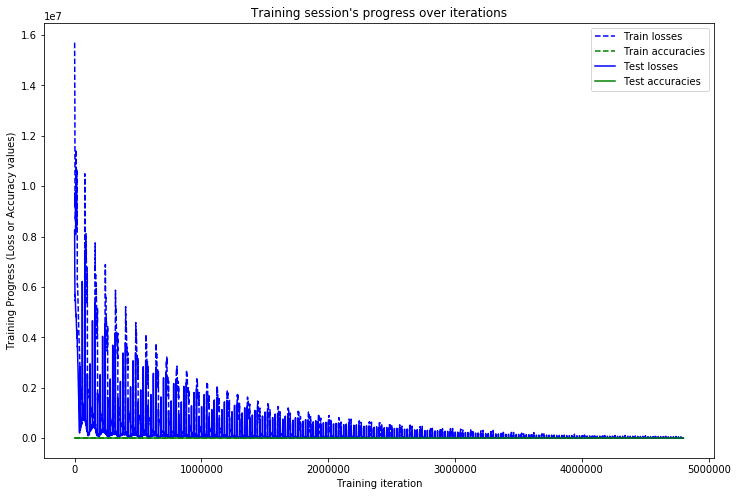

In [17]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 94.7702540256%
Recall: 94.11%
f1_score: 93.5551048786%

Confusion Matrix:
[[    0    18     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0   482     0    35    57    50    81    17    97     0     0     0
     92     0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0     0]
 [    0     0     0     0     0     0     0     2     0     0     0     0
      0     0]
 [    0     7     0     0  2793    10     0    12     1     0     0     3
     65     0]
 [    0    46     0     7     0   287     0     0     1     0     0     0
      7     0]
 [    0     7     0     2     0     0 14486     0     0     0     0     0
      0     0]
 [    0    17     0     3    35   333    24    48    32     0     0     2
     41     0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0     0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in divide


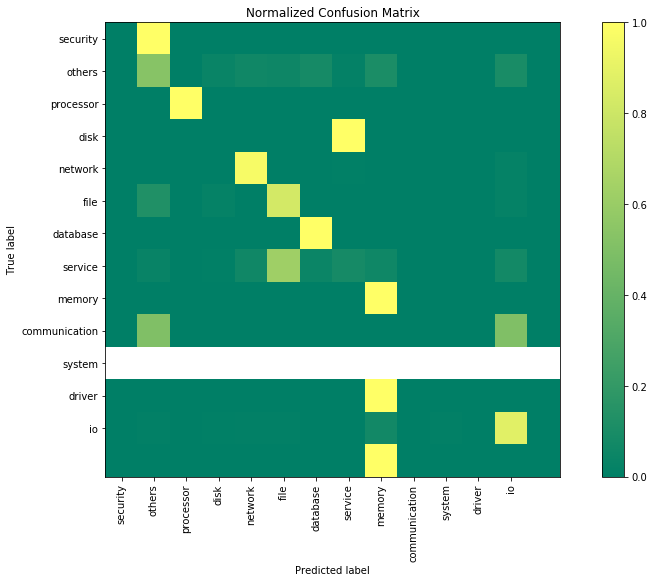

In [18]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)